In [2]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from matplotlib import pyplot as plt 
from ipywidgets import interact

# Cluster properties

In [3]:
colors = {
    'Polyketide' : 'deeppink',
    'NRP' : 'green',
    'RiPP' : 'blue',
    'NRP;Polyketide' : 'indigo',
    'Other' : 'orange',
    'Saccharide' : 'red',
    'Terpene': 'turquoise',
    'Alkaloid' : 'yellow',
    'Negative' : 'black'
}

In [4]:
properties = pd.read_csv('../data/mibig/mibig_properties.csv').set_index('contig_id')
properties.head()

,BGC_ID,num_proteins,classes,source,species
contig_id,,,,,
BGC0000001.1,BGC0000001,28,Polyketide,Verrucosispora maris AB-18-032,Verrucosispora
BGC0000002.1,BGC0000002,34,Polyketide,Kutzneria albida DSM 43870,Kutzneria
BGC0000003.1,BGC0000003,6,Polyketide,Alternaria alternata,Alternaria
BGC0000004.1,BGC0000004,23,Polyketide,Aspergillus oryzae,Aspergillus
BGC0000005.1,BGC0000005,1,Polyketide,Aspergillus parasiticus,Aspergillus


## Number of clusters per class

In [5]:
properties['classes'].value_counts()

Polyketide                     434
NRP                            247
RiPP                           206
NRP;Polyketide                 174
Other                          163
Saccharide                     128
Terpene                         91
Alkaloid                        28
Polyketide;Saccharide           28
?                               16
Polyketide;Terpene              16
Saccharide;Terpene               6
NRP;Polyketide;Saccharide        6
Terpene;Alkaloid                 5
Terpene;Polyketide               4
NRP;Saccharide                   4
NRP;Other                        3
Saccharide;Other                 3
NRP;Alkaloid                     3
Polyketide;Saccharide;Other      2
Saccharide;Polyketide            1
Polyketide;NRP                   1
Polyketide;Other;Saccharide      1
NRP;Terpene                      1
NRP;Terpene;Alkaloid             1
Terpene;Saccharide               1
Polyketide;Alkaloid              1
NRP;RiPP                         1
NRP;Polyketide;Other

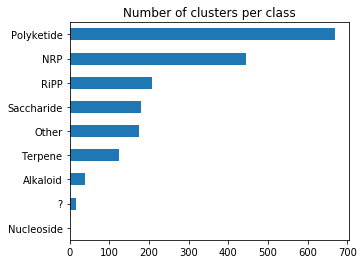

In [6]:
class_sublists = properties['classes'].apply(lambda c: c.split(';'))
classes = [c for classes in class_sublists for c in classes]
pd.Series(classes).value_counts().sort_values().plot.barh(figsize=(5,4), title='Number of clusters per class')

## Sources counts

In [7]:
len(properties['source'].unique())

908

Text(0.5,0,'Number of clusters')

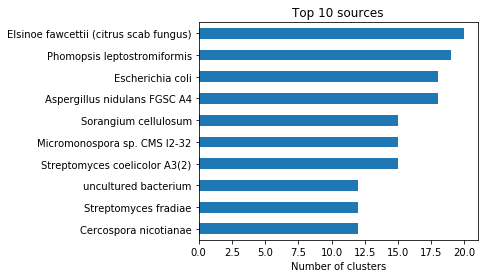

In [8]:
ax = properties['source'].value_counts().sort_values()[-10:].plot.barh(figsize=(5,4), title='Top 10 sources')
ax.set_xlabel('Number of clusters')

## Species counts (first word in source)

In [9]:
properties['species'] = properties['source'].apply(lambda source: source.split()[0])
len(properties['species'].unique())

236

Text(0.5,0,'Number of clusters')

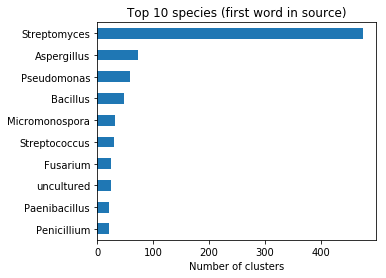

In [10]:
ax = properties['species'].value_counts().sort_values()[-10:].plot.barh(figsize=(5,4), title='Top 10 species (first word in source)')
ax.set_xlabel('Number of clusters')

# Cluster domain sequences

In [11]:
#get all pfam domains for each BGC
domains = pd.read_csv('../data/mibig/mibig_domains.csv')
max_evalue = 0.01
domains = domains[domains['evalue'] < max_evalue]
domains.head()

,contig_id,locus_tag,protein_id,gene_start,gene_end,gene_strand,pfam_id,domain_start,domain_end,evalue,bitscore
0,BGC0000001.1,unknown_locus_tag,AEK75490.1,0,1083,1,PF13649,0,73,5.000000e-08,33.4
1,BGC0000001.1,unknown_locus_tag,AEK75490.1,0,1083,1,PF08241,0,51,2.300000e-03,18.5
4,BGC0000001.1,unknown_locus_tag,AEK75490.1,0,1083,1,PF13847,3,63,1.100000e-09,38.2
6,BGC0000001.1,unknown_locus_tag,AEK75490.1,0,1083,1,PF13489,12,62,5.100000e-04,19.8
11,BGC0000001.1,unknown_locus_tag,AEK75490.1,0,1083,1,PF02353,35,109,9.000000e-03,15.2


## Domain counts

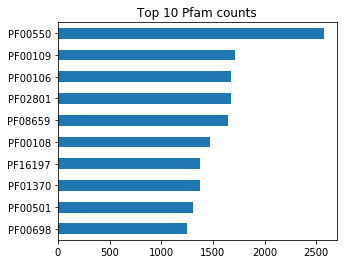

In [12]:
domains['pfam_id'].value_counts().sort_values()[-10:].plot.barh(figsize=(5,4), title='Top 10 Pfam counts')

## Number of domains

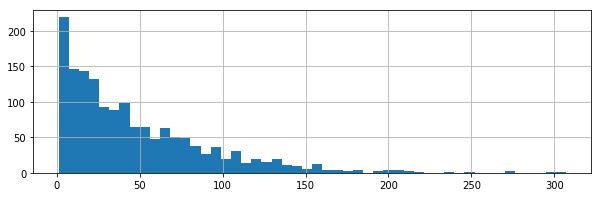

In [13]:
sequence_lengths = domains.groupby('contig_id').count()['pfam_id']
sequence_lengths.hist(bins=50, figsize=(10,3))

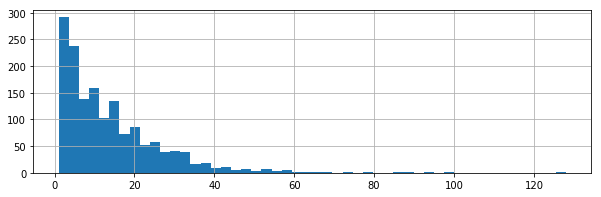

In [14]:
protein_counts = domains.groupby('contig_id')['protein_id'].nunique()
protein_counts.hist(bins=50, figsize=(10,3))

## Per-class stats

In [15]:
multiclasses = [c for c in properties['classes'].unique() if ';' not in c and '?' not in c]
multiclasses

['Polyketide',
 'Other',
 'Saccharide',
 'Alkaloid',
 'NRP',
 'RiPP',
 'Terpene',
 'Nucleoside']

In [16]:
def top_pfam_counts(domains, limit=10):
    return domains['pfam_id'].value_counts() / len(domains)

In [17]:
def plot_pfam_counts(multiclass, counts):
    counts[::-1].plot.barh(title=multiclass+': Top pfams', figsize=(5,2))
    plt.show()

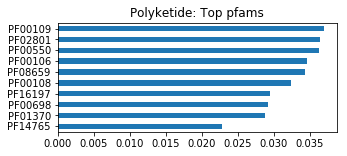

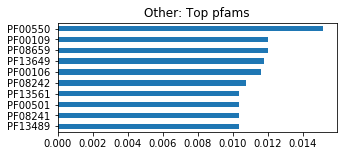

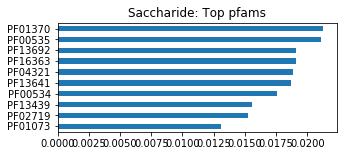

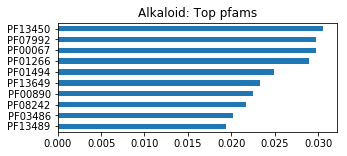

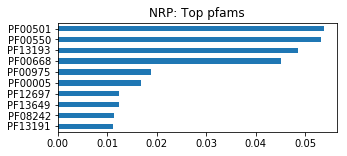

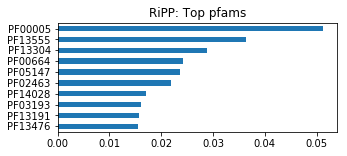

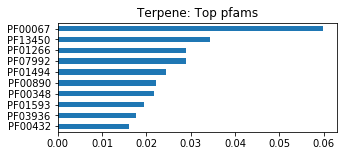

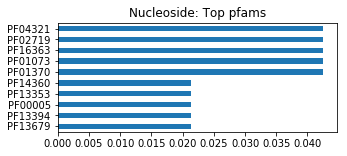

In [18]:
all_counts = []
for multiclass in multiclasses:
    ids = properties[properties['classes'] == multiclass].index.unique()
    counts = top_pfam_counts(domains.set_index('contig_id').loc[ids])
    plot_pfam_counts(multiclass, counts[:10])
    all_counts += list(counts[:20].index)

In [19]:
neg_domains = pd.read_csv('../data/training/negative/geneswap_negatives.csv')

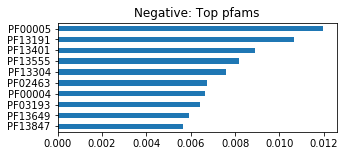

In [20]:
neg_counts = top_pfam_counts(neg_domains)
plot_pfam_counts('Negative', neg_counts[:10])

## Pfam2vec t-SNE curve

In [24]:
tsne = pd.read_csv('../data/features/pfam2vec-experiments/tsne/pfam2vec_top.tsne2.csv').set_index('pfam_id')
tsne.head()

,a,b
pfam_id,,
</s>,67.537670,-13.862064
PF00005,6.450087,9.167074
PF13191,-21.920673,-15.914155
PF13555,6.274451,9.044004
PF13304,6.255480,8.958315


In [25]:
def plot_bgc_curve(bgc_id):
    bgc_pfams = domains[domains['contig_id']==bgc_id]['pfam_id']
    bgc_coords = tsne.loc[bgc_pfams]
    bgc_coords.head()
    bgc_class = properties.loc[bgc_id]['classes']
    title = '{} (class {}, {} domains)'.format(bgc_id, bgc_class, len(bgc_pfams))
    ax = tsne.plot.scatter(x='a',y='b', figsize=(13, 13), s=5, title=title)
    ax.title.set_size(20)
    ax.plot(bgc_coords['a'], bgc_coords['b'], '.r-')
    plt.show()

In [26]:
interact(plot_bgc_curve, bgc_id=domains['contig_id'].unique())

A Jupyter Widget

<function __main__.plot_bgc_curve>

## Domain set similarity

In [144]:
domains_by_cluster = domains.groupby('contig_id')
bgcs_domains = [list(seq['pfam_id']) for cluster_id, seq in domains_by_cluster]
bgc_identifiers = pd.Series([cluster_id for cluster_id, seq in domains_by_cluster], name='contig_id')
print('First identifier: ', bgc_identifiers[0])
print('First list of domains (truncated): ', bgcs_domains[0][:6])

First identifier:  BGC0000001.1
First list of domains (truncated):  ['PF13649', 'PF08241', 'PF13847', 'PF13489', 'PF02353', 'PF01596']


In [145]:
all_pfams = [item for sublist in bgcs_domains for item in sublist] #get flat list
unique_pfams = sorted(list(set(all_pfams))) #all unique pfams from the results

#create a matrix where rows = all BGCs, columns = all unique Pfams; 1 = BGC has the corresponding Pfam
print("Creating domain matrix...")
domain_matrix = pd.DataFrame(0, index = bgc_identifiers, columns = unique_pfams)
for i, bgc in enumerate(bgcs_domains):
    domain_matrix.loc[bgc_identifiers[i], bgc] = 1

#get correlation matrix for all BGCs
print("Computing correlation matrix...")
domain_corr_matrix = domain_matrix.T.corr()

#info
print("Number of BCSs:\t\t", len(bgcs_domains))
print("Number of all Pfams:\t", len(all_pfams))
print("Number of unique Pfams:\t", len(unique_pfams))
#print("--- %s seconds ---" % (time.time() - start_time))

Creating domain matrix...
Computing correlation matrix...
Number of BCSs:		 1551
Number of all Pfams:	 91889
Number of unique Pfams:	 3277


In [146]:
domain_matrix.head()

,PF00004,PF00005,PF00006,PF00009,PF00010,PF00011,PF00012,PF00013,PF00015,PF00022,...,PF17387,PF17389,PF17390,PF17391,PF17392,PF17414,PF17425,PF17508,PF17584,PF17608
contig_id,,,,,,,,,,,,,,,,,,,,,
BGC0000001.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000002.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000003.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000004.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000005.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


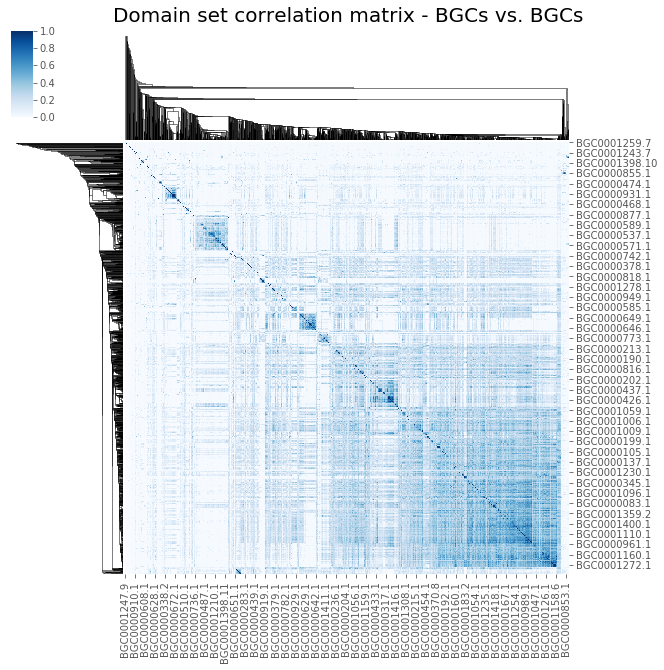

In [36]:
#generate heatmap for correlation and distance matrices
 
# correlation matrix clustermap
domain_corr_matrix.index = domain_matrix.index
sns.clustermap(domain_corr_matrix,
               metric="correlation",
               method="single",
               cmap="Blues",
               standard_scale=1)
plt.text(4.6, 1.1, 'Domain set correlation matrix - BGCs vs. BGCs', fontsize=20)
plt.show()

Computing distance matrix...


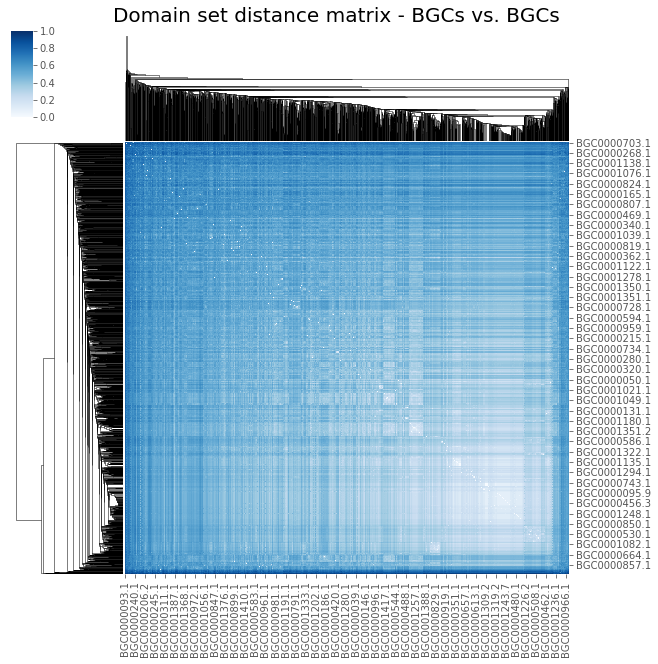

In [37]:
# distance matrix clustermap
#get distance matrix
print("Computing distance matrix...")
distances = pdist(domain_matrix.values, metric = 'euclidean')
domain_dist_matrix = squareform(distances)

domain_dist_matrix = pd.DataFrame(domain_dist_matrix, index = domain_corr_matrix.index, columns = domain_corr_matrix.columns)
sns.clustermap(domain_dist_matrix,
               metric="euclidean",
               method="single",
               cmap="Blues",
               standard_scale=1)
plt.text(4.6, 1.1, 'Domain set distance matrix - BGCs vs. BGCs', fontsize=20)
plt.show()
#plt.savefig('dist_matrix_clustermap.png')